In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
cd ../src

/atlas/u/kechoi/multi-fairgen/src


# Load omniglot (as in tf)

In [4]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

In [5]:
with open('/atlas/u/kechoi/multi-fairgen/src/configs/classification/omniglot/baseline.yaml') as f:
    config = yaml.load(f)
config = dict2namespace(config)

/atlas/u/kechoi/software/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


### import real data

In [6]:
import torch
from torchvision.datasets import Omniglot
from torch.utils.data import Subset
import torchvision.transforms as T

In [7]:
x = np.load('../../DAGAN/datasets/omniglot_data.npy')

In [8]:
np.min(x)

0.0

In [9]:
np.max(x)

1.0

### import fake data

In [24]:
data = np.load('/atlas/u/kechoi/DAGAN/datasets/generated_omniglot/generated_omniglot.npy')

In [25]:
bias_data = data

In [26]:
bias_data.shape

(1622, 100, 28, 28)

In [27]:
bias_data.shape

(1622, 100, 28, 28)

In [28]:
xhat = bias_data.reshape(-1, 100, 28, 28, 1)
xhat.shape

(1622, 100, 28, 28, 1)

In [29]:
xhat = xhat/255.

# Load pretrained classifier

In [38]:
# x = torch.from_numpy(x).float()
x = x.permute((0,1,4,2,3))
x = x.view(-1, 1, 28, 28)
x.size()

torch.Size([32440, 1, 28, 28])

In [41]:
# xhat = torch.from_numpy(xhat).float()
xhat = xhat.permute((0,1,4,2,3))
xhat = xhat.view(-1, 1, 28, 28)
xhat.size()

torch.Size([162200, 1, 28, 28])

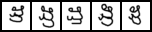

In [68]:
from torchvision.utils import save_image
from IPython.display import Image

save_image(x[10:15], 'test.png')
Image('test.png')

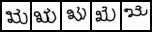

In [69]:
save_image(xhat[10:15], 'test.png')
Image('test.png')

In [44]:
from classification.models.cnn import BinaryCNNClassifier

In [50]:
device = 'cuda'
model = BinaryCNNClassifier()
model = model.to(device)

# load checkpoint
clf_path = '/atlas/u/kechoi/multi-fairgen/src/classification/results/omniglot_x_dre_clf/checkpoints/model_best.pth'
print('loading clf from {}'.format(clf_path))
state = torch.load(clf_path)
model.load_state_dict(state['state_dict'])
model.eval()

loading clf from /atlas/u/kechoi/multi-fairgen/src/classification/results/omniglot_x_dre_clf/checkpoints/model_best.pth


BinaryCNNClassifier(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), 

In [65]:
input_x = torch.cat([x[10:15], xhat[10:15]], dim=0)
input_x.size()

torch.Size([10, 1, 28, 28])

In [66]:
logits, probas = model(input_x.cuda())
probas = probas.squeeze()
ratios = probas/(1-probas).squeeze()

Text(0.5, 1.0, 'X-Space Density ratios')

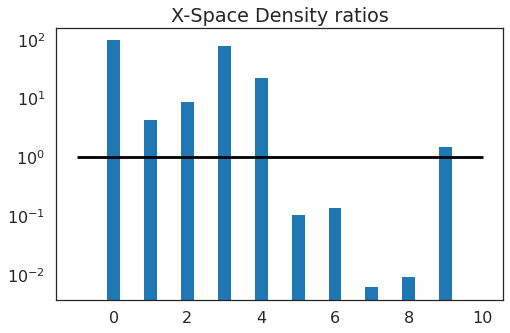

In [73]:
plt.figure(figsize=(8,5))
ind = np.arange(len(ratios))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, ratios.data.cpu().numpy(), width)
plt.hlines(1, -1, 10, color='black')
plt.yscale('log')
plt.title('X-Space Density ratios')

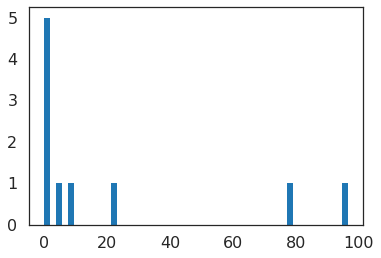

In [71]:
_ = plt.hist(ratios.data.cpu().numpy(), bins=50)